In [1]:
import pyroomacoustics as pra
from scipy.io.wavfile import write

import os
import yaml
from tqdm import tqdm

import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

from einops import rearrange

from src.dataset import SignalDataset, TRUNetDataset
from src.loss import loss_tot, loss_MR, loss_MR_w
from NISQA_s.src.core.model_torch import model_init
from NISQA_s.src.utils.process_utils import process
from models.fspen import FullSubPathExtension

import librosa

import matplotlib.pyplot as plt

import warnings

In [2]:
# DATA_DIR = os.path.join("..", "data", "musan", "speech")
DATA_DIR = os.path.join("..", "data", "DS_10283_2791")
TRAIN_DIR = os.path.join(DATA_DIR, "clean_trainset_56spk_wav")

TEST_DIR = os.path.join(DATA_DIR, "clean_testset_wav")
# TRAIN_DIR = os.path.join(DATA_DIR, "train_chunks")
# TEST_DIR = os.path.join(DATA_DIR, "test_chunks")
RIR_DIR = os.path.join("..", "data", "RIRs")
# RIR_DIR = os.path.join("..", "data", "rirs_noises", "RIRS_NOISES", "real_rirs")
# NOISE_DIR = os.path.join("..", "data", "test-noise", "noise", "white")
NOISE_DIR = os.path.join("..", "data", "rirs_noises", "RIRS_NOISES", "real_rirs_isotropic_noises")
CHKP_DIR = os.path.join("..", "checkpoints")
NISQA_PATH = "../NISQA_s/config/nisqa_s.yaml"
np.set_printoptions(precision=3)
torch.set_printoptions(precision=3)


In [3]:
SEED = 1984

np.random.seed(SEED)
torch.manual_seed(SEED)

gen = torch.Generator()
gen.manual_seed(SEED)

In [4]:
N_FFTS = 512
HOP_LENGTH = 256 # int(0.01625 * 16_000) # 256
# N_FFTS = 1024
# HOP_LENGTH = 512

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"It's {DEVICE} time!!!")
N_DEVICES = max(torch.cuda.device_count(), 1)

It's cuda time!!!


In [5]:
with open(NISQA_PATH, 'r') as stream:
    nisqa_args = yaml.safe_load(stream)
nisqa_args["ms_n_fft"] = N_FFTS
nisqa_args["hop_length"] = HOP_LENGTH
nisqa_args["ms_win_length"] = N_FFTS

In [6]:
nisqa, h0_nisqa, c0_nisqa = model_init(nisqa_args)

/home/zakhar/miniconda3/envs/ems_dereverb/lib/python3.10/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [7]:
train_dataset = TRUNetDataset(TRAIN_DIR, sr=16_000, noise_dir=NOISE_DIR, rir_dir=RIR_DIR, snr=(0, 20), return_noise=False, return_rir=False)
test_dataset = TRUNetDataset(TEST_DIR, sr=16_000, noise_dir=NOISE_DIR, snr=(0, 20), rir_dir=RIR_DIR, return_noise=False, return_rir=False)

In [8]:
def vorbis_window(winlen, device="cuda"):
    sq = torch.sin(torch.pi/2*(torch.sin(torch.pi/winlen*(torch.arange(winlen)-0.5))**2)).float()
    return sq

In [9]:
def pad_sequence(batch):
    if not batch:
        return torch.zeros(0), torch.zeros(0)

    input_signal, target_signal, noise, rir = zip(*batch)
        
    max_len_s = max(s.shape[-1] for s in input_signal)
    
    padded_input = torch.zeros(len(input_signal), max_len_s)
    padded_target = torch.zeros(len(target_signal), max_len_s)
    
    for i, s in enumerate(input_signal):
        padded_input[i, :s.shape[-1]] = s
        padded_target[i, :s.shape[-1]] = target_signal[i]

    return padded_input, padded_target

def collate_fn(batch):
    
    padded_input, padded_target = pad_sequence(batch)
    
    # padded_input = padded_input.unfold(-1, 16_000 * 2, 16_000)
    # padded_target = padded_target.unfold(-1, 16_000 * 2, 16_000)
    
    window = vorbis_window(N_FFTS)
    
    padded_input = padded_input.reshape(-1, padded_input.shape[-1])
    input_spec = torch.stft(
            padded_input,
            n_fft=N_FFTS,
            hop_length=HOP_LENGTH,
            # onesided=True,
            win_length=N_FFTS,
            window=window,
            return_complex=True,
            normalized=True,
            center=True
        ) 
    to_gt_spec = padded_input.reshape(-1, padded_target.shape[-1])
    gt_spec = torch.stft(
            to_gt_spec,
            n_fft=N_FFTS,
            hop_length=HOP_LENGTH,
            # onesided=True,
            win_length=N_FFTS,
            window=window,
            return_complex=True,
            normalized=True,
            center=True
        ) 
    
    padded_target = padded_target.reshape(-1, padded_target.shape[-1])

    return input_spec, padded_target, gt_spec

In [10]:
train_dataloader = DataLoader(train_dataset, batch_size=8 * N_DEVICES, shuffle=True, drop_last=True, collate_fn=collate_fn, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=8 * N_DEVICES, shuffle=False, drop_last=False, collate_fn=collate_fn, num_workers=4)

In [11]:
def train(model, train_loader, optimizer, with_noise=True, with_rir=True, device="cuda", epoch=0, draw_every=1):
    total_train_loss = 0
    total_train_loss_mr = 0
    total_train_loss_mr_w = 0
    total_train_abs_loss = 0
    total_train_angle_loss = 0
    # MOS NOI DISC COL LOUD
    total_train_nisqa = torch.zeros(5)
    # ind = 0
    out = None
    noisy_in = None
    model.train()
    for input_spec, gt_signal, gt_spec in tqdm(train_loader, desc="Train model "):
        optimizer.zero_grad()

        input_spec = input_spec.to(device)
        gt_signal = gt_signal.to(device)

        input_spec_ = input_spec
        abs_spectrum = input_spec.abs()
        input_spec = torch.permute(torch.view_as_real(input_spec), dims=(0, 2, 3, 1))
        batch, frames, channels, frequency = input_spec.shape
        
        abs_spectrum = torch.permute(abs_spectrum, dims=(0, 2, 1))
        abs_spectrum = torch.reshape(abs_spectrum, shape=(batch, frames, 1, frequency))
        # h0 = torch.randn(1, batch * 16, 16 // 8, device=device)
        # h0 = [[torch.randn(1, batch * 32, 16 // 8, device=device) for _ in range(8)]
        #               for _ in range(3)]

        output, _ = model(input_spec, abs_spectrum)
        output = torch.permute(output, dims=(0, 3, 1, 2))
        output = torch.view_as_complex(output)
        # output_d, output_n, output_r, _, _ = model(input_spec, h_f, h_t)

        # output_d = torch.polar(torch.abs(output_d), input_spec.angle())

        window = vorbis_window(N_FFTS).to(device)
        # print(output_d.shape, input_spec.shape)
        out_wave = torch.istft(output, n_fft=N_FFTS, hop_length=HOP_LENGTH, win_length=N_FFTS,
                               window=window,
                               # onesided=True,
                               return_complex=False,
                               normalized=True,
                               center=True)#, length=gt_signal.shape[-1])
        min_l = min(out_wave.shape[-1], gt_signal.shape[-1])
        loss_mr = loss_MR(out_wave[..., :min_l], gt_signal[..., :min_l], nffts=[128, 256, 512, 1024, 2048]) * 10
        # loss_mr_w = loss_MR_w(out_wave, gt_signal)
        
        loss = loss_mr # + loss_mr_w
        
        loss.backward()
        optimizer.step()
        # print(out_wave.shape)
        nisqa_score, _, _ = process(out_wave.detach().cpu(), 16_000, nisqa, h0_nisqa, c0_nisqa, nisqa_args)
        
        total_train_nisqa += nisqa_score[0]
        
        total_train_loss += loss.detach().item()  
        total_train_loss_mr += loss_mr.detach().item()
        total_train_loss_mr_w += 0 # loss_mr_w.detach().item()
        total_train_abs_loss += 0 # mask_loss_abs.detach().item()
        total_train_angle_loss += 0 # mask_loss_angle.detach().item()
        
        # out = out_wave.cpu().detach().numpy()[0]
        # noisy_in = input_spec_.cpu().detach()
        
    # if epoch % 2 == 0:
    #     write('output.wav', 16_000, out)
    #     window = vorbis_window(N_FFTS)
    #     noisy_in = torch.istft(noisy_in, n_fft=N_FFTS, hop_length=HOP_LENGTH, win_length=N_FFTS,
    #                            window=window,
    #                            # onesided=True,
    #                            return_complex=False,
    #                            normalized=True,
    #                            center=True)
    #     write('input_sig.wav', 16_000, noisy_in.numpy()[0])
    return (model, optimizer, total_train_loss / len(train_loader), total_train_loss_mr / len(train_loader), 
            total_train_loss_mr_w / len(train_loader), total_train_abs_loss / len(train_loader), total_train_angle_loss / len(train_loader),
            total_train_nisqa / len(train_loader))
            
def evaluate(model, test_loader, with_noise=True, with_rir=True, device="cuda", epoch=0):
    total_test_loss = 0
    total_test_loss_mr = 0
    total_test_loss_mr_w = 0
    total_test_abs_loss = 0
    total_test_angle_loss = 0
    total_test_nisqa = torch.zeros(5)
    model.eval()
    with torch.no_grad():
        for input_spec, gt_signal, gt_spec in tqdm(test_loader, desc="Test model "):
            input_spec = input_spec.to(device)
            gt_signal = gt_signal.to(device)
            
            abs_spectrum = input_spec.abs()
            input_spec = torch.permute(torch.view_as_real(input_spec), dims=(0, 2, 3, 1))
            batch, frames, channels, frequency = input_spec.shape
            abs_spectrum = torch.permute(abs_spectrum, dims=(0, 2, 1))
            abs_spectrum = torch.reshape(abs_spectrum, shape=(batch, frames, 1, frequency))
            # h0 = [[torch.randn(1, batch * 32, 16 // 8, device=device) for _ in range(8)]
            #            for _ in range(3)]
            output, _ = model(input_spec, abs_spectrum)
            
            output = torch.permute(output, dims=(0, 3, 1, 2))
            output = torch.view_as_complex(output)
    
            # output_d, output_n, output_r, _, _ = model(input_spec, h_f, h_t)
            # output_d = torch.polar(torch.abs(output_d), input_spec.angle())

            window = vorbis_window(N_FFTS).to(device)
            out_wave = torch.istft(output, n_fft=N_FFTS, hop_length=HOP_LENGTH, win_length=N_FFTS,
                                   window=window,
                                   return_complex=False,
                                   normalized=True,
                                   center=True)
            # out_wave, _ = SignalDataset.normalize_audio(out_wave)
            # out_wave = 2 * (out_wave - out_wave.min()) / (out_wave.max() - out_wave.min() + 1e-8) - 1
            min_l = min(out_wave.shape[-1], gt_signal.shape[-1])
            loss_mr = loss_MR(out_wave[..., :min_l], gt_signal[..., :min_l], nffts=[128, 256, 512, 1024, 2048]) * 10
            # loss_mr_w = loss_MR_w(out_wave, gt_signal) # + loss_MR_w(out_noise, noise) + loss_MR_w(out_rir, rir)
            
            loss = loss_mr # + loss_mr_w # + mask_loss_abs + mask_loss_angle

            total_test_loss += loss.detach().item()
            total_test_loss_mr += loss_mr.detach().item()
            total_test_loss_mr_w += 0 # loss_mr_w.detach().item()
            total_test_abs_loss += 0 # mask_loss_abs.detach().item()
            total_test_angle_loss += 0 # mask_loss_angle.detach().item()
            
            nisqa_score, _, _ = process(out_wave.detach().cpu(), 16_000, nisqa, h0_nisqa, c0_nisqa, nisqa_args)
        
            total_test_nisqa += nisqa_score[0]
     
    return (total_test_loss / len(test_loader), total_test_loss_mr / len(test_loader),
            total_test_loss_mr_w / len(test_loader), total_test_abs_loss / len(test_loader), total_test_angle_loss / len(test_loader),
            total_test_nisqa / len(test_loader))
    

In [12]:
from IPython.display import clear_output

def get_model_name(chkp_folder, model_name=None):
    # Выбираем имя чекпоинта для сохранения
    if model_name is None:
        if os.path.exists(chkp_folder):
            num_starts = len(os.listdir(chkp_folder)) + 1
        else:
            num_starts = 1
        model_name = f'model#{num_starts}'
    else:
        if "#" not in model_name:
            model_name += "#0"
    changed = False
    while os.path.exists(os.path.join(chkp_folder, model_name + '.pt')):
        model_name, ind = model_name.split("#")
        model_name += f"#{int(ind) + 1}"
        changed=True
    if changed:
        warnings.warn(f"Selected model_name was used already! To avoid possible overwrite - model_name changed to {model_name}")
    return model_name

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def learning_loop(
    model,
    optimizer,
    train_loader,
    val_loader,
    scheduler=None,
    min_lr=None,
    epochs=10,
    val_every=1,
    draw_every=1,
    with_noise=True,
    with_rir=True,
    model_name=None,
    chkp_folder="../checkpoints/fspen_chkp",
    plots=None,
    starting_epoch=0,
    device="cuda",
):
    model_name = get_model_name(chkp_folder, model_name)
    
    if plots is None:
        plots = {
            'train loss': [],
            'train loss_mr': [],
            'train loss_mr_w': [],
            'train loss_mask_abs': [],
            'train loss_mask_angle': [],
            'val loss': [],
            'val loss_mr': [],
            'val loss_mr_w': [],
            'val loss_mask_abs': [],
            'val loss_mask_angle': [],
            'train NISQA': [],
            'val NISQA': [],
            "learning rate": [],
        }

    max_mos = 0

    for epoch in np.arange(1, epochs+1) + starting_epoch:
        print(f'#{epoch}/{epochs}:')

        plots['learning rate'].append(get_lr(optimizer))
        
        (model, optimizer, train_loss, train_loss_mr, train_loss_mr_w, 
         train_loss_mask_abs, train_loss_mask_angle, train_nisqa) = train(model, train_loader, optimizer, with_noise=with_noise, with_rir=with_rir, device=device, epoch=epoch, draw_every=draw_every)
        # print(train_nisqa)
        plots['train loss'].append(train_loss)
        plots['train loss_mr'].append(train_loss_mr)
        plots['train loss_mr_w'].append(train_loss_mr_w)
        plots['train loss_mask_abs'].append(train_loss_mask_abs)
        plots['train loss_mask_angle'].append(train_loss_mask_angle)
        plots['train NISQA'].append(train_nisqa[None, :].cpu())
        

        if not (epoch % val_every):
            # print("validate")
            (val_loss, val_loss_mr, val_loss_mr_w, 
             val_loss_mask_abs, val_loss_mask_angle, val_nisqa) = evaluate(model, val_loader, with_noise=with_noise, with_rir=with_rir, device=device)
            plots['val loss'].append(val_loss)
            plots['val loss_mr'].append(val_loss_mr)
            plots['val loss_mr_w'].append(val_loss_mr_w)
            plots['val loss_mask_abs'].append(val_loss_mask_abs)
            plots['val loss_mask_angle'].append(val_loss_mask_angle)
            plots['val NISQA'].append(val_nisqa[None, :].cpu())
            
            # Сохраняем модель
            if not os.path.exists(chkp_folder):
                os.makedirs(chkp_folder)
            
            # if max_mos <= val_nisqa[0]:
            torch.save(
                {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'plots': plots,
                },
                os.path.join(chkp_folder, model_name + '.pt'),
            )
            max_mos = val_nisqa[0]
            
            # Шедулинг
            if scheduler:
                try:
                    scheduler.step()
                except:
                    scheduler.step(metrics=val_loss)

        if not (epoch % draw_every):
            clear_output(True)

            hh = 4
            ww = 2
            plt_ind = 1
            fig, ax = plt.subplots(hh, ww, figsize=(25, 12))
            fig.suptitle(f'#{epoch}/{epochs}:')


            plt.subplot(hh, ww, plt_ind)
            plt.title('Learning rate')
            plt.plot(plots["learning rate"], 'b.-', label='lr', alpha=0.7)
            plt.legend()
            plt_ind += 1

            plt.subplot(hh, ww, plt_ind)
            plt.title('Loss')
            plt.plot(np.arange(1, epoch + 1), plots['train loss'], 'r.-', label='train', alpha=0.7)
            plt.plot(np.arange(1, epoch + 1), plots['val loss'], 'g.-', label='val', alpha=0.7)
            plt.grid()
            plt.legend()
            plt_ind += 1
            
            plt.subplot(hh, ww, plt_ind)
            plt.title('Loss MR')
            plt.plot(np.arange(1, epoch + 1), plots['train loss_mr'], 'r.-', label='train', alpha=0.7)
            plt.plot(np.arange(1, epoch + 1), plots['val loss_mr'], 'g.-', label='val', alpha=0.7)
            plt.grid()
            plt.legend()
            plt_ind += 1
            
            plt.subplot(hh, ww, plt_ind)
            plt.title('Loss MR W')
            plt.plot(np.arange(1, epoch + 1), plots['train loss_mr_w'], 'r.-', label='train', alpha=0.7)
            plt.plot(np.arange(1, epoch + 1), plots['val loss_mr_w'], 'g.-', label='val', alpha=0.7)
            plt.grid()
            plt.legend()
            plt_ind += 1
            
            plt.subplot(hh, ww, plt_ind)
            plt.title('Loss Mask abs')
            plt.plot(np.arange(1, epoch + 1), plots['train loss_mask_abs'], 'r.-', label='train', alpha=0.7)
            plt.plot(np.arange(1, epoch + 1), plots['val loss_mask_abs'], 'g.-', label='val', alpha=0.7)
            plt.grid()
            plt.legend()
            plt_ind += 1
            
            plt.subplot(hh, ww, plt_ind)
            plt.title('Loss Mask angle')
            plt.plot(np.arange(1, epoch + 1), plots['train loss_mask_angle'], 'r.-', label='train', alpha=0.7)
            plt.plot(np.arange(1, epoch + 1), plots['val loss_mask_angle'], 'g.-', label='val', alpha=0.7)
            plt.grid()
            plt.legend()
            plt_ind += 1

            nisqa_plot = torch.cat(plots['train NISQA'])
            # if len(nisqa_plot.shape) == 1:
            #     nisqa_plot = nisqa_plot[None, :]
            # print(nisqa_plot.shape)
            plt.subplot(hh, ww, plt_ind)
            plt.title('Train NISQA')
            plt.plot(np.arange(1, epoch + 1), nisqa_plot[:, 0], '.-', label='MOS', alpha=0.7, markersize=20, color="blue")
            plt.plot(np.arange(1, epoch + 1), nisqa_plot[:, 1], '.-', label='NOI', alpha=0.7, markersize=20, color="red")
            plt.plot(np.arange(1, epoch + 1), nisqa_plot[:, 2], '.-', label='DISC', alpha=0.7, markersize=20, color="green")
            plt.plot(np.arange(1, epoch + 1), nisqa_plot[:, 3], '.-', label='COL', alpha=0.7, markersize=20, color="yellow")
            plt.plot(np.arange(1, epoch + 1), nisqa_plot[:, 4], '.-', label='LOUD', alpha=0.7, markersize=20, color="pink")
            plt.grid()
            plt.legend()
            plt_ind += 1

            nisqa_plot = torch.cat(plots['val NISQA'], dim=0)
            # if len(nisqa_plot.shape) == 1:
            #     nisqa_plot = nisqa_plot[None, :]
            plt.subplot(hh, ww, plt_ind)
            plt.title('Val NISQA')
            plt.plot(np.arange(1, epoch + 1), nisqa_plot[:, 0], '.-', label='MOS', alpha=0.7, markersize=20, color="blue")
            plt.plot(np.arange(1, epoch + 1), nisqa_plot[:, 1], '.-', label='NOI', alpha=0.7, markersize=20, color="red")
            plt.plot(np.arange(1, epoch + 1), nisqa_plot[:, 2], '.-', label='DISC', alpha=0.7, markersize=20, color="green")
            plt.plot(np.arange(1, epoch + 1), nisqa_plot[:, 3], '.-', label='COL', alpha=0.7, markersize=20, color="yellow")
            plt.plot(np.arange(1, epoch + 1), nisqa_plot[:, 4], '.-', label='LOUD', alpha=0.7, markersize=20, color="pink")
            plt.grid()
            plt.legend()
            plt_ind += 1

            plt.show()
            display(fig)
                        
        if min_lr and get_lr(optimizer) <= min_lr:
            print(f'Learning process ended with early stop after epoch {epoch}')
            break

    
    return model, optimizer, plots

In [13]:
from torch.optim import Adam, AdamW
from src.fspen_configs import TrainConfig

configs = TrainConfig()
print(sum(configs.bands_num_in_groups), configs.dual_path_extension["num_modules"])
fspen = FullSubPathExtension(configs=configs).to(DEVICE) # TRUNet(nfft=N_FFTS, hop=HOP_LENGTH).cuda()

optimizer = Adam(fspen.parameters(), lr=5e-3)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, eta_min=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 4, gamma=0.8, last_epoch=-1)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, cooldown=1, patience=3, threshold=0.1, mode="min", threshold_mode="abs")

32 3


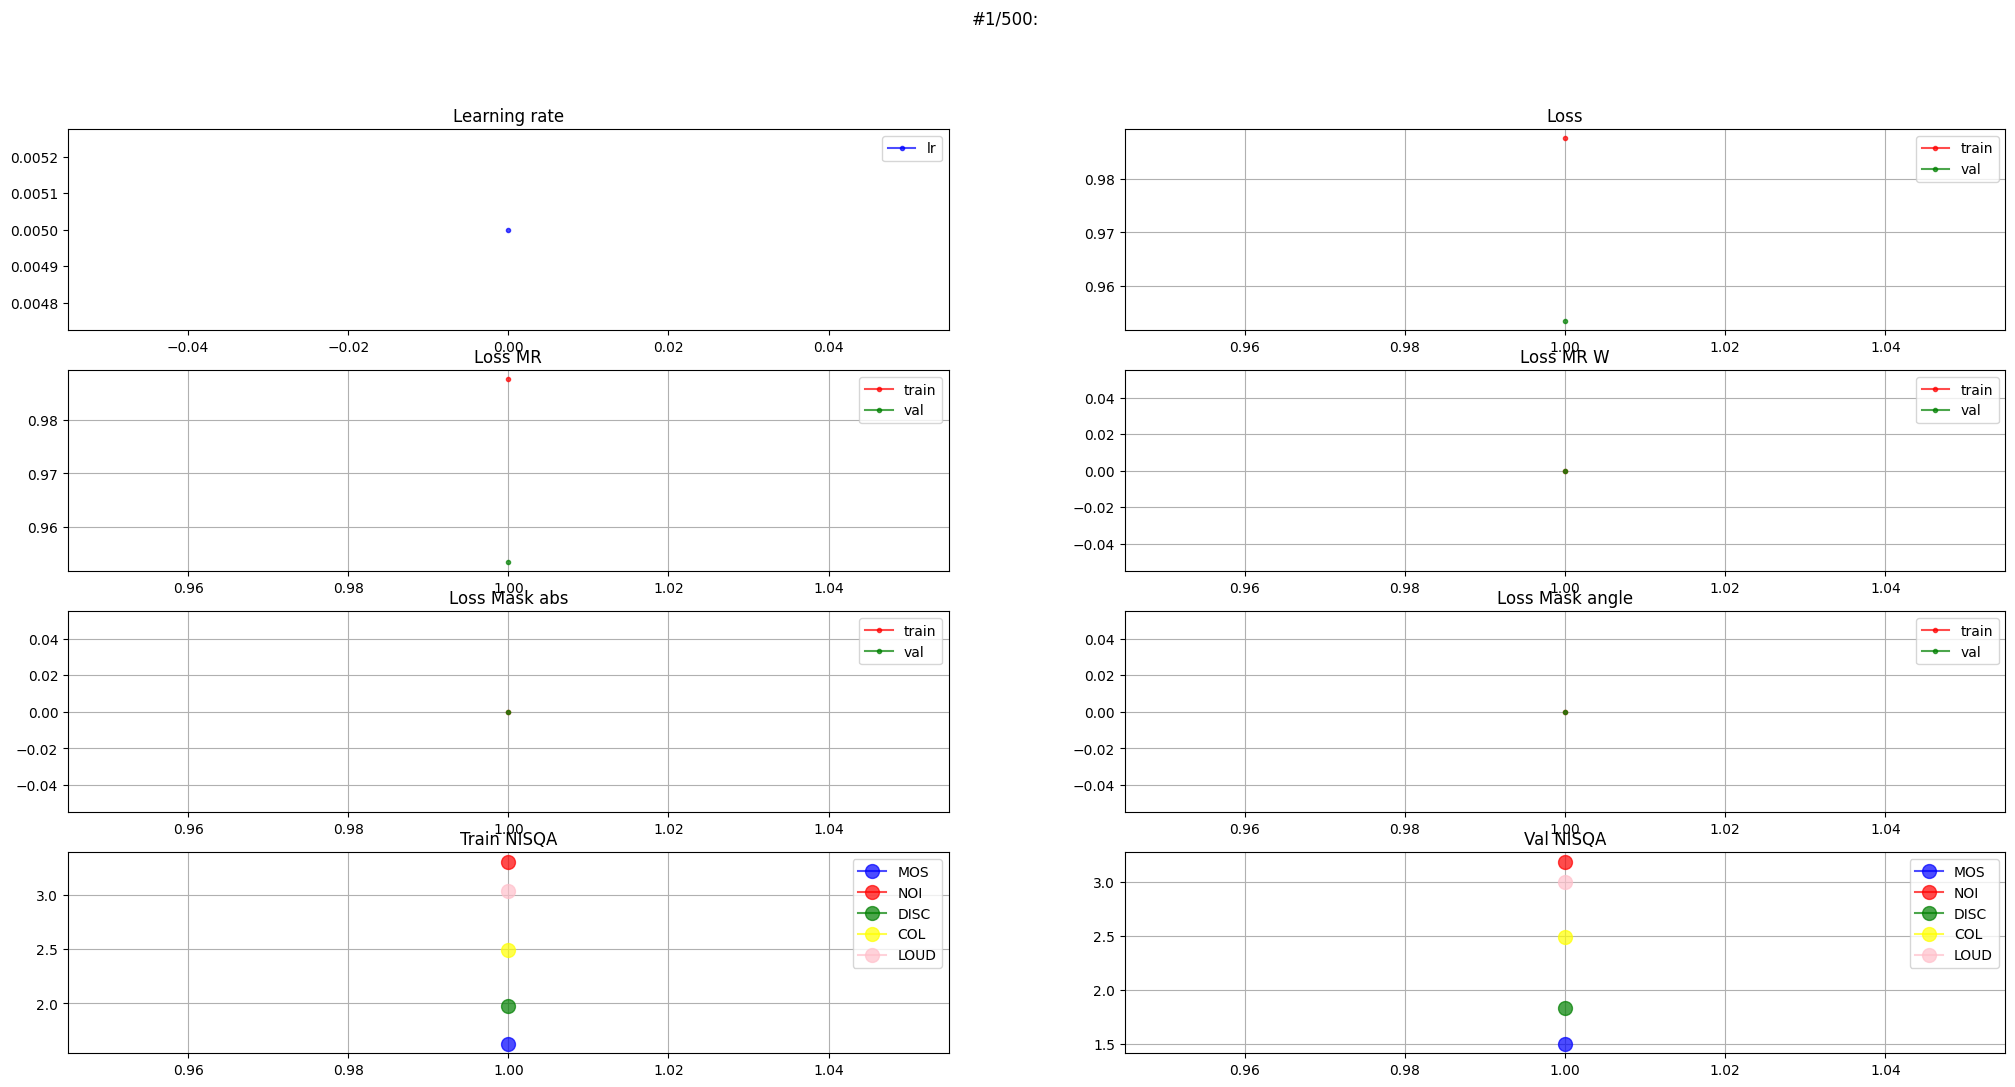

#2/500:


Train model :  18%|█▊        | 533/2884 [00:59<04:20,  9.02it/s]

KeyboardInterrupt



In [14]:
fspen, optimizer, plots = learning_loop(fspen, optimizer, train_dataloader, test_dataloader, scheduler, draw_every=1, epochs=500, min_lr=1e-8, with_noise=False, with_rir=False, model_name="fspen_voicebank_subband_loss")

In [ ]:
# state_d = torch.load(os.path.join(CHKP_DIR, "fspen_chkp", "fspen_voicebank_reverb#5.pt"), weights_only=False)
# 
# fspen.load_state_dict(state_d["model_state_dict"])
# optimizer.load_state_dict(state_d["optimizer_state_dict"])
# scheduler.load_state_dict(state_d["scheduler_state_dict"])
# plots = state_d["plots"]

In [ ]:
# trunet, optimizer, plots = learning_loop(fspen, optimizer, train_dataloader, test_dataloader, scheduler, draw_every=1, epochs=500, min_lr=1e-8, with_noise=False, with_rir=False, model_name="fspen_voicebank_reverb", plots=plots, starting_epoch=state_d["epoch"])